In [1]:
#!pip install -U scikit-learn

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
import pickle
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from sklearn.preprocessing import OneHotEncoder
from scipy.special import softmax
#import pandas.core.common import flatten

C:\Users\ayoid\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


For step:  100 the results are:  [{'ACC': 51.03}, {'Zero One Loss': 0.49}]


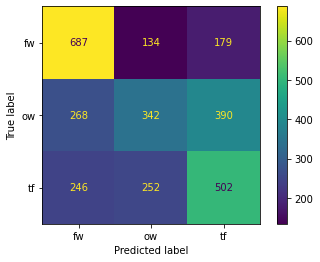

In [4]:
#Testing tuned hyper-parameter on newly generated data to check for overftiing
import pickle
#no_of_robots_steps = 100

def get_step_results(no_of_robot_steps):
    fixed_wheel_x = np.loadtxt(str(no_of_robot_steps) + "_steps_fixed_xs_test.csv", delimiter=',')
    fixed_wheel_y = np.loadtxt(str(no_of_robot_steps) + "_steps_fixed_ys_test.csv", delimiter=',')
    fixed_wheel_theta = np.loadtxt(str(no_of_robot_steps) + "_steps_fixed_thetas_test.csv", delimiter=',')

    omni_wheel_x = np.loadtxt(str(no_of_robot_steps) + "_steps_omni_xs_test.csv", delimiter=',')
    omni_wheel_y = np.loadtxt(str(no_of_robot_steps) + "_steps_omni_ys_test.csv", delimiter=',')
    omni_wheel_theta = np.loadtxt(str(no_of_robot_steps) + "_steps_omni_thetas_test.csv", delimiter=',')

    two_wheel_x = np.loadtxt(str(no_of_robot_steps) + "_steps_two_fixed_xs_test.csv", delimiter=',')
    two_wheel_y = np.loadtxt(str(no_of_robot_steps) + "_steps_two_fixed_ys_test.csv", delimiter=',')
    two_wheel_theta = np.loadtxt(str(no_of_robot_steps) + "_steps_two_fixed_thetas_test.csv", delimiter=',')

    #Get parameters of the dataframe we will need to build
    len_of_steps = len(fixed_wheel_x[0])
    total_len_of_columns = len_of_steps * 3
    total_pose_size = len(fixed_wheel_x.flatten()) + len(fixed_wheel_y.flatten()) + len(fixed_wheel_theta.flatten())
    total_pose_size = int(total_pose_size/total_len_of_columns)

    #print("Number of robot steps: ", len_of_steps, "\nLenght of columns for steps (x,y,theta): ",total_len_of_columns, "\nTotal number of samples: ", total_pose_size)

    #Expose and reshape the measurements in the respective wheels 
    #to build a dataframe for the wheeltype
    fixed_wheel_poses = np.column_stack((fixed_wheel_x.flatten(),fixed_wheel_y.flatten(),fixed_wheel_theta.flatten()))
    fixed_wheel_poses = np.reshape(fixed_wheel_poses,(total_pose_size,total_len_of_columns))

    omni_wheel_poses = np.column_stack((omni_wheel_x.flatten(),omni_wheel_y.flatten(),omni_wheel_theta.flatten()))
    omni_wheel_poses = np.reshape(omni_wheel_poses,(total_pose_size,total_len_of_columns))
    
    two_fixed_wheel_poses = np.column_stack((two_wheel_x.flatten(),two_wheel_y.flatten(),two_wheel_theta.flatten()))
    two_fixed_wheel_poses = np.reshape(two_fixed_wheel_poses,(total_pose_size,total_len_of_columns))

    #Creating the column names. Each measurement contains a X,y and theta value
    x_headings = ["step x " + str(i+1) for i in range(int(total_len_of_columns/3))]
    y_headings = ["step y " + str(i+1) for i in range(int(total_len_of_columns/3))]
    theta_headings = ["step theta " + str(i+1) for i in range(int(total_len_of_columns/3))]
    headings = []
    for i in range(0,len(x_headings)):
        headings.append(x_headings[i])
        headings.append(y_headings[i])
        headings.append(theta_headings[i])
    #headings = x_headings + y_headings + theta_headings
    #headings

    #Creating the respective wheel dataframes
    fixed_p = pd.DataFrame(fixed_wheel_poses, columns = headings)
    omni_p = pd.DataFrame(omni_wheel_poses, columns = headings)
    two_fixed_p = pd.DataFrame(two_fixed_wheel_poses, columns = headings)

    #Tagging class labels in a new column with the wheel type 
    #and joining the dataframes into one, we shuffle the dataframe
    #and reset the index
    fixed_p.insert(0,'Model type', 'fw')
    omni_p.insert(0,'Model type', 'ow')
    two_fixed_p.insert(0,'Model type', 'tf')
    wheel_poses = pd.concat([fixed_p, omni_p, two_fixed_p])
    wheel_poses = wheel_poses.iloc[np.random.RandomState(seed=16).permutation(len(wheel_poses))]
    wheel_poses = wheel_poses.reset_index(drop=True)
    
    y = wheel_poses['Model type']
    X = wheel_poses.drop(columns='Model type')
    
    model_lr = pickle.load(open(str(no_of_robot_steps) + '_steps_LR_robot_model_weights.sav', 'rb'))
    y_pred_lr_test = model_lr.predict(X)
    
    dic_acc = {}
    dic_zol = {}

    confusion_matrix = metrics.plot_confusion_matrix(model_lr, X, y)
    dic_acc['ACC'] = round(metrics.accuracy_score(y, y_pred_lr_test)*100,2)
    dic_zol['Zero One Loss'] = round(metrics.zero_one_loss(y, y_pred_lr_test),2)
    
    
    return dic_acc, dic_zol


#steps = [5, 10, 20, 50, 100]
#steps = [100, 500, 1000, 2000, 5000, 10000]

step_dic = {}
#Collects the accuracy and log loss for each step
steps = [100]

for no_of_robot_steps in steps:
    step_acc, step_zol = get_step_results(no_of_robot_steps)
    step_dic[no_of_robot_steps] = [step_acc, step_zol]
    
#k_list = []
#v_list = []
#z_list = []
for k, v in step_dic.items():
    print("For step: ", k, "the results are: ", v )


    

    
